#Building Agentic RAG Pipelines for Financial Document Analysis with Contextual AI

The agentic nature in **Agentic RAG System** lies in the system's ability to autonomously analyze incoming queries, determine what reformulation strategy is needed, and execute that strategy without explicit user instruction.

 **Traditional RAG** systems take queries as-is, often leading to poor retrievals for ambiguous, context-lacking, or complex queries. **Agentic RAG** intelligently preprocesses queries to bridge this gap. In the query path, the primary agentic step is **query reformulation**, comprising multi-turn, query expansion, or query decomposition. This query reformulation step is critical to obtaining the most robust RAG results, and is one component of a system engineered to generate the most accurate query responses.


*   **Query reformulation**: Context is added or queries are restructured from the original input
*   **Multi-turn**: Iterative dialogue context is added

*   **Query expansion**:Added additional context to help a short query return optimal results
*   **Query decomposition**: Taken complex multi-faceted queries that require reasoning across several unrelated documents, and broken them down into several sub-queries that help obtain the most relevant retrievals

 <div align="center">
 <img src="https://github.com/ContextualAI/examples/blob/main/images/architecture.png?raw=true" alt="Contextual Architecture" width="1000"/>
 </div>


Set up the Agentic RAG system by learning to:
 - **Configure document datastores** with indexing tuned for RAG performance  
 - **Deploy production-ready agents** with robust instructions and safeguards  
 - **Query the system interactively** using natural language while maintaining strict grounding  
 - **Continuously validate and improve** your pipeline with automated testing and performance metrics  

**Four fundamental RAG components in Contextual AI**:

 1. **Parser** - Ingest and structure heterogeneous documents (reports, tables, figures) for retrieval.  
 2. **Reranker** - Dynamically select the most relevant evidence to ensure precise grounding.  
 3. **Grounded Language Model (GLM)** - Generate factual, source-backed responses using the retrieved context.  
 4. **Language Model Unit Tests (LMUnits)** - Automatically evaluate and optimize the accuracy, grounding, and reliability of your agent.  
 ---

# Building a RAG Agent from Scratch


##  Environment Setup
 The `contextual-client` library provides Python bindings for the Contextual AI platform, while the additional packages support data visualization and progress tracking.

In [2]:
# Install required packages for Contextual AI integration and data visualization
%pip install contextual-client matplotlib tqdm requests pandas dotenv

Next, we'll import the necessary libraries that we'll use throughout this tutorial:

In [3]:
import os
import json
import requests
from pathlib import Path
from typing import List, Optional, Dict
from IPython.display import display, JSON
import pandas as pd
from contextual import ContextualAI
import ast
from IPython.display import display, Markdown
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

---

## 🔑 Step 1: API Authentication Setup


### Configuring Your API Key

To run this tutorial, you can store your API key in a `.env` file. This keeps your keys separate from your code. After setting up your .env file, you can load the API key from `.env` to initialize the Contextual AI client.

In [4]:
import os
from google.colab import userdata

API_KEY = userdata.get('CONTEXTUAL_API_KEY')

if API_KEY is None:
    raise ValueError("CONTEXTUAL_API_KEY not found in Colab Secrets")

client = ContextualAI(api_key=API_KEY)


---

## 📊 Step 2: Create Your Document Datastore

### Understanding Datastores

A **datastore** in Contextual AI is a secure, isolated container for your documents and their processed representations. Each datastore provides:

- **Isolated Storage**: Documents are kept separate and secure for each use case
- **Intelligent Processing**: Automatic parsing, chunking, and indexing of uploaded documents
- **Optimized Retrieval**: High-performance search and ranking capabilities

Let's create a datastore for our financial document analysis agent:

In [5]:
datastore_name = 'Financial_Demo_RAG'

# Check if datastore exists
datastores = client.datastores.list()
existing_datastore = next((ds for ds in datastores if ds.name == datastore_name), None)

if existing_datastore:
    datastore_id = existing_datastore.id
    print(f"Using existing datastore with ID: {datastore_id}")
else:
    result = client.datastores.create(name=datastore_name)
    datastore_id = result.id
    print(f"Created new datastore with ID: {datastore_id}")

Using existing datastore with ID: 88373a76-86a1-46b5-87c1-05036fe9bf0d


---

## 📄 Step 3: Document Ingestion and Processing

Now that your agent's datastore is set up, let's add some financial documents to it. Contextual AI's document processing engine provides **enterprise-grade parsing** that expertly handles:

- **Complex Tables**: Financial data, spreadsheets, and structured information
- **Charts and Graphs**: Visual data extraction and interpretation
- **Multi-page Documents**: Long reports with hierarchical structure

For this tutorial, we'll use sample financial documents that demonstrate various challenging scenarios:

In [6]:
import os
import requests

# Create data directory if it doesn't exist
if not os.path.exists('data'):
    os.makedirs('data')

# File list with corresponding GitHub URLs
files_to_upload = [
    # NVIDIA quarterly revnue 24/25
    ("A_Rev_by_Mkt_Qtrly_Trend_Q425.pdf", "https://raw.githubusercontent.com/ContextualAI/examples/refs/heads/main/08-ai-workshop/data/A_Rev_by_Mkt_Qtrly_Trend_Q425.pdf"),
    # NVIDIA quarterly revenue 22/23
    ("B_Q423-Qtrly-Revenue-by-Market-slide.pdf", "https://raw.githubusercontent.com/ContextualAI/examples/refs/heads/main/08-ai-workshop/data/B_Q423-Qtrly-Revenue-by-Market-slide.pdf"),
    # Spurious correlations report - fun example of graphs and statistical analysis
    ("C_Neptune.pdf", "https://raw.githubusercontent.com/ContextualAI/examples/refs/heads/main/08-ai-workshop/data/C_Neptune.pdf"),
    # Another spurious correlations report - fun example of graphs and statistical analysis
    ("D_Unilever.pdf", "https://raw.githubusercontent.com/ContextualAI/examples/refs/heads/main/08-ai-workshop/data/D_Unilever.pdf")
]

### Document Download and Ingestion Process
The following cell downloads example documents locally from the GitHub links above, uploads them to Contextual AI, and tracks their processing status and IDs.

In [7]:
# Download and ingest all files
document_ids = []
for filename, url in files_to_upload:
    file_path = f'data/{filename}'

    # Download file if it doesn't exist
    if not os.path.exists(file_path):
        print(f"Fetching {file_path}")
        try:
            response = requests.get(url)
            response.raise_for_status()  # Raise an exception for bad status codes
            with open(file_path, 'wb') as f:
                f.write(response.content)
        except Exception as e:
            print(f"Error downloading {filename}: {str(e)}")
            continue

    # Upload to datastore
    try:
        with open(file_path, 'rb') as f:
            ingestion_result = client.datastores.documents.ingest(datastore_id, file=f)
            document_id = ingestion_result.id
            document_ids.append(document_id)
            print(f"Successfully uploaded {filename} to datastore {datastore_id}")
    except Exception as e:
        print(f"Error uploading {filename}: {str(e)}")

print(f"Successfully uploaded {len(document_ids)} files to datastore")
print(f"Document IDs: {document_ids}")

Fetching data/A_Rev_by_Mkt_Qtrly_Trend_Q425.pdf
Successfully uploaded A_Rev_by_Mkt_Qtrly_Trend_Q425.pdf to datastore 88373a76-86a1-46b5-87c1-05036fe9bf0d
Fetching data/B_Q423-Qtrly-Revenue-by-Market-slide.pdf
Successfully uploaded B_Q423-Qtrly-Revenue-by-Market-slide.pdf to datastore 88373a76-86a1-46b5-87c1-05036fe9bf0d
Fetching data/C_Neptune.pdf
Successfully uploaded C_Neptune.pdf to datastore 88373a76-86a1-46b5-87c1-05036fe9bf0d
Fetching data/D_Unilever.pdf
Successfully uploaded D_Unilever.pdf to datastore 88373a76-86a1-46b5-87c1-05036fe9bf0d
Successfully uploaded 4 files to datastore
Document IDs: ['760bcc16-222e-4220-af85-2f2550b32ee1', '9e895e30-9a50-42ef-90cb-b93841e30d69', '4ac2f308-9d57-41ac-ab6e-1fa66dfd4dcc', '18bb984b-089d-47f6-b528-73ae68917b50']


In [8]:
metadata = client.datastores.documents.metadata(datastore_id = datastore_id, document_id = document_ids[0])
print("Document metadata:", metadata)

Document metadata: DocumentMetadata(id='760bcc16-222e-4220-af85-2f2550b32ee1', created_at='2025-12-28T08:38:39.843139', name='A_Rev_by_Mkt_Qtrly_Trend_Q425.pdf', status='processing', custom_metadata={}, custom_metadata_config={}, has_access=True, ingestion_config={'parsing': {'figure_captioning_prompt': None, 'figure_caption_mode': 'default', 'enable_split_tables': False, 'max_split_table_cells': 100, 'ingestion_tier': None, 'enable_table_revision': None, 'ocr_level': 'auto', 'use_hyperlink_extraction': False, 'enable_vlm_hierarchy_inference': True, 'layout_model': 'dit', 'extractor_type': None, 'vlm_captioning_model': None, 'vlm_hierarchy_model': None, 'vlm_doc_name_model': None, 'vlm_markdown_reviser_model': None, 'vlm_table_reviser_model': None, 'vlm_fallback_ocr_model': None, 'enable_table_reviser_thinking': None, 'postprocess_workflow_yaml': None, 'postprocess_workflow_inputs_json': None, 'use_streaming': True}, 'chunking': {'chunking_mode': 'hierarchy_depth', 'max_chunk_length_to

---

## 🤖 Step 4: Agent Creation and Configuration

Now you'll create our RAG agent that will interact with the documents you just ingested.

You can customize the Agent using additional parameters such as:

- **`system_prompt`** is used for the instructions that your RAG system references when generating responses. Note that this is the default prompt as of 9.02.25.
- **`suggested_queries`** is a user experience feature, to prepopulate queries for the agent so a new user can see interesting examples.  

💡 Pro Tip: You can also configure or edit your agent in the UI at [app.contextual.ai](https://app.contextual.ai?utm_campaign=rag-techniques&utm_source=diamantai&utm_medium=github&utm_content=notebook), try changing the generation model to another LLM!  

You can find all the additional parameters [here](https://docs.contextual.ai/api-reference/agents/create-agent?utm_campaign=rag-techniques&utm_source=diamantai&utm_medium=github&utm_content=notebook)

In [9]:
system_prompt = '''
You are a helpful AI assistant created by Contextual AI to answer questions about relevant documentation provided to you. Your responses should be precise, accurate, and sourced exclusively from the provided information. Please follow these guidelines:
* Only use information from the provided documentation. Avoid opinions, speculation, or assumptions.
* Use the exact terminology and descriptions found in the provided content.
* Keep answers concise and relevant to the user's question.
* Use acronyms and abbreviations exactly as they appear in the documentation or query.
* Apply markdown if your response includes lists, tables, or code.
* Directly answer the question, then STOP. Avoid additional explanations unless specifically relevant.
* If the information is irrelevant, simply respond that you don't have relevant documentation and do not provide additional comments or suggestions. Ignore anything that cannot be used to directly answer this query.
'''

agent_name = "Finance_Context"

# Get list of existing agents
agents = client.agents.list()

# Check if agent already exists
existing_agent = next((agent for agent in agents if agent.name == agent_name), None)

if existing_agent:
    agent_id = existing_agent.id
    print(f"Using existing agent with ID: {agent_id}")
else:
    print("Creating new agent")
    app_response = client.agents.create(
        name=agent_name,
        description="Helpful Grounded AI Assistant",
        datastore_ids=[datastore_id],
        agent_configs={
        "global_config": {
            "enable_multi_turn": False # Turning this off for deterministic responses for this demo
        }
        },
        suggested_queries=[
            "What was NVIDIA's annual revenue by fiscal year 2022 to 2025?",
            "When did NVIDIA's data center revenue overtake gaming revenue?",
            "What's the correlation between the distance between Neptune and the Sun and Burglary rates in the US?",
            "What's the correlation between Global revenue generated by Unilever Group and Google searches for 'lost my wallet'?",
            "Does this imply that Unilever Group's revenue is derived from lost wallets?",
            "What's the correlation between the distance between Neptune and the Sun and Global revenue generated by Unilever Group?"
        ]
    )
    agent_id = app_response.id
    print(f"Agent ID created: {agent_id}")

Using existing agent with ID: 62075bdf-5a88-4d96-a6bc-045fedc1c090


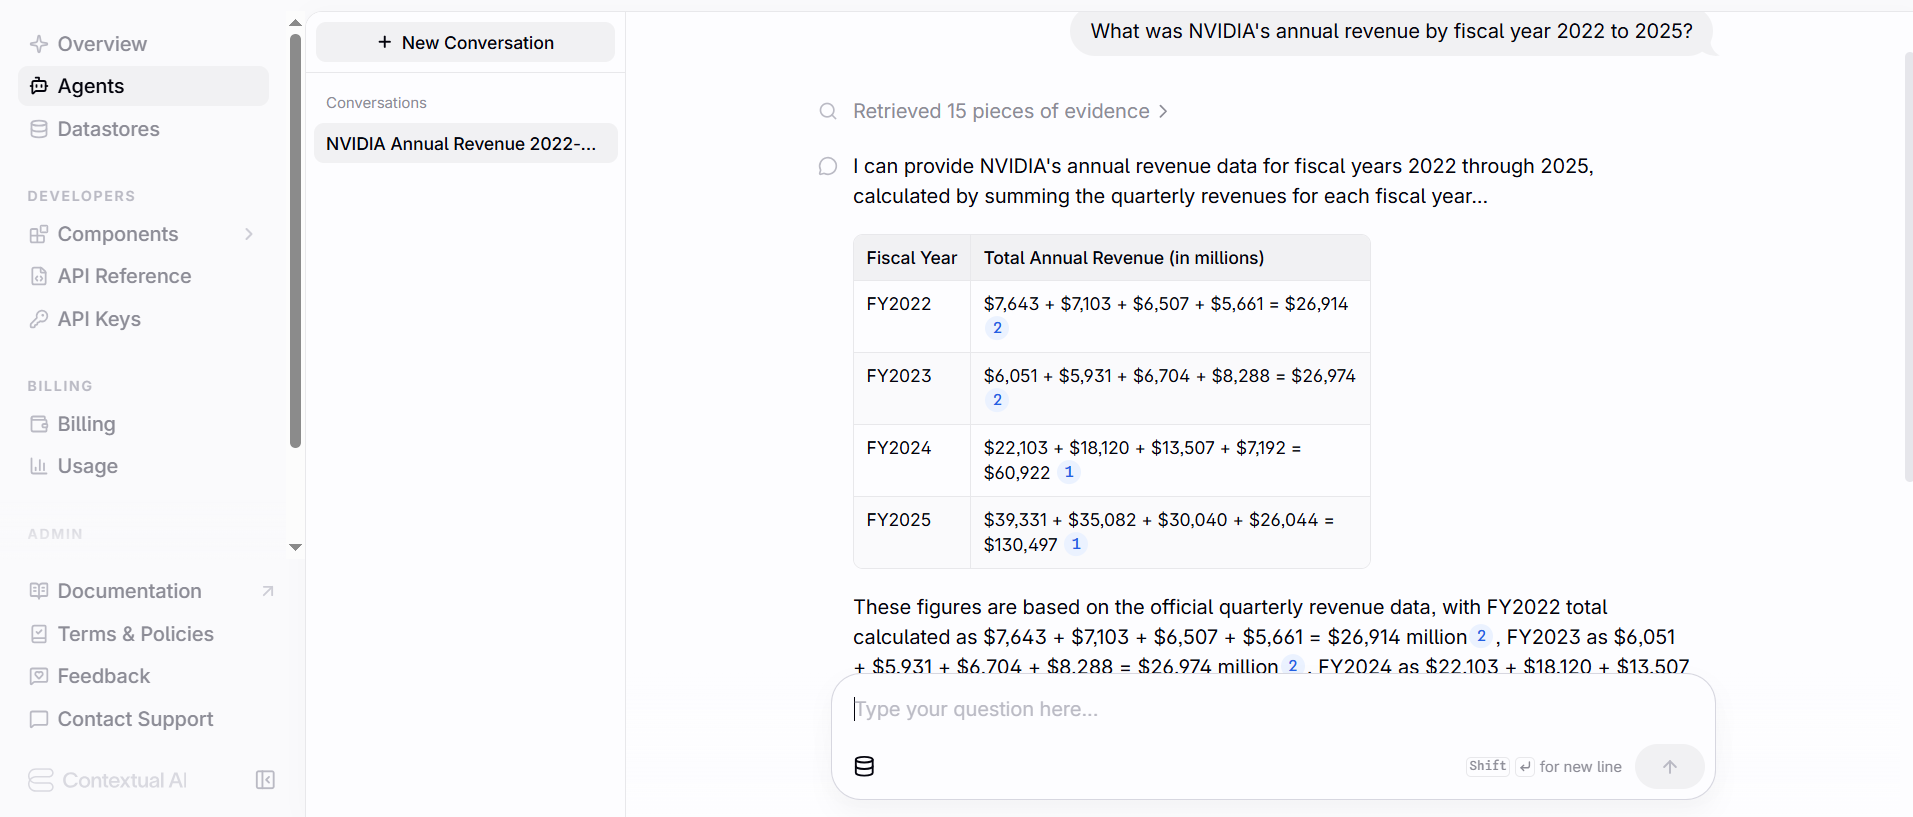

In [11]:
from IPython.display import Image, display

display(Image(filename="/content/Trial.png", width=1000))


---

## 💬 Step 5: Query the Agent

### Testing Your RAG Agent

Now that our agent is configured and connected to our financial documents, let's test its capabilities with various types of queries.

The required fields are:

- **`agent_id`**: The unique identifier of your Agent  
- **`messages`**: A list of message(s) forming the user query  

The Financial Report Of Google is uploaded manually through the [app.contextual.ai](https://app.contextual.ai?utm_campaign=rag-techniques&utm_source=diamantai&utm_medium=github&utm_content=notebook)

In [12]:
query_result = client.agents.query.create(
    agent_id=agent_id,
    messages=[{
        "content": "Write a brief analysis of NVIDIA Quarterly Revenue Trend for Q4-2025",
        "role": "user"
    }]
)
print(query_result.message.content)

NVIDIA's total revenue for Q4 FY25 reached $39,331 million, showing an increase from $35,082 million in Q3 FY25 and $22,103 million in Q4 FY24.[2]()

| Segment | Q4 FY25 Revenue ($M) | YoY Growth (vs Q4 FY24) |
|---------|---------------------|------------------------|
| Data Center | $35,580 | +93.5% (vs $18,404) |
| Gaming | $2,544 | -11.1% (vs $2,865) |
| Professional Visualization | $511 | +10.4% (vs $463) |
| Auto | $570 | +103.2% (vs $281) |
| OEM & Other | $126 | +40.0% (vs $90)[2]()

Key observations from Q4 FY25 performance:
- Data Center segment drives the majority of revenue and shows exceptional growth
- Gaming segment shows a notable decline despite being the second-largest contributor
- Auto segment demonstrates strong percentage growth, though from a smaller base

Looking at the sequential trend, Data Center revenue increased from $30,771M in Q3 FY25 to $35,580M in Q4 FY25, while Gaming revenue decreased from $3,279M to $2,544M in the same period.[2]()

The quarterly res

In [13]:
query_result = client.agents.query.create(
    agent_id=agent_id,
    messages=[{
        "content": "How did the $3.5B EC fine impact Alphabet’s operating margin in Q3 2025, and what would the margin have been without it?",
        "role": "user"
    }]
)
print(query_result.message.content)

Alphabet's operating margin for Q3 2025 was 30.5% on a GAAP basis, while the operating margin excluding the $3.5 billion EC fine (Non-GAAP) was 33.9%.[1]()

| Metric | With EC Fine (GAAP) | Without EC Fine (Non-GAAP) |
|--------|-------------------|--------------------------|
| Operating Margin | 30.5% | 33.9% |[1]() 
| Operating Income | $31,228M | $34,685M |[2]() 

The $3.5 billion charge related to the European Commission (EC) fine was recorded in Q3 2025, and when excluded, operating income increased 22% versus 9% on a GAAP basis, benefiting from strong revenue growth and continued efficiencies in the expense base.[1]()

On September 5, 2025, the EC announced its decision that Google had infringed European competition laws, resulting in the $3.5 billion fine which was accrued in general and administrative expenses in the Google Services segment for the three months ended September 30, 2025.[4]()


There is lots more information you can access from the query result. You can display the retrieved documents, for example.   


--- Processing Document 1 ---
  Page/Image 1


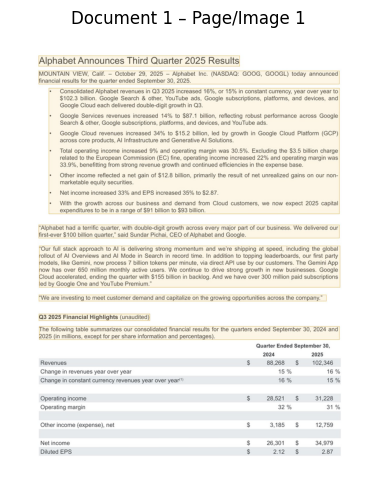


--- Processing Document 2 ---
  Page/Image 1


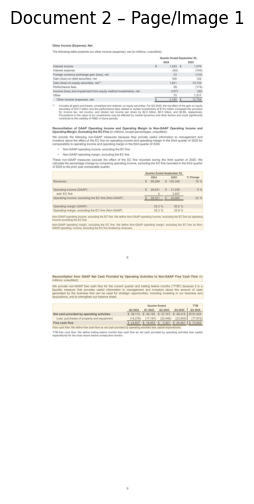


--- Processing Document 3 ---
  Page/Image 1


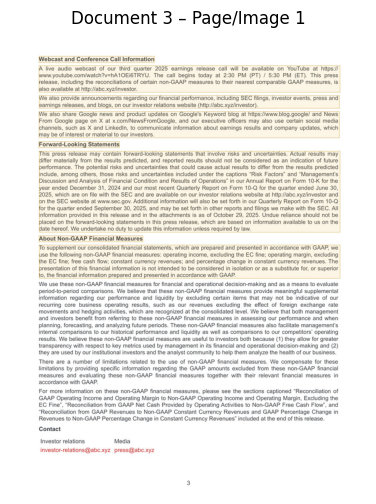


--- Processing Document 4 ---
  Page/Image 1


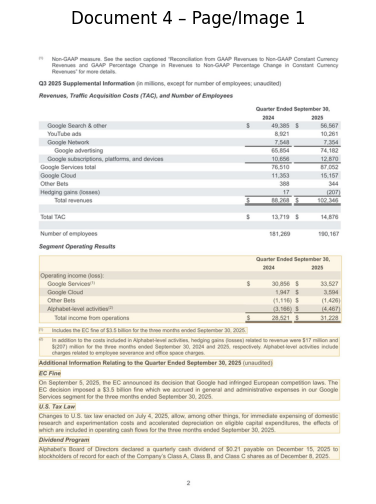


--- Processing Document 5 ---
  Page/Image 1


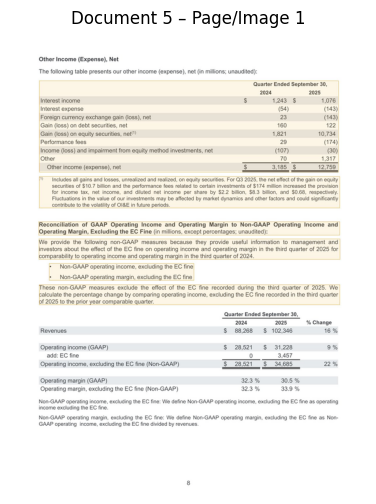


--- Processing Document 6 ---
  Page/Image 1


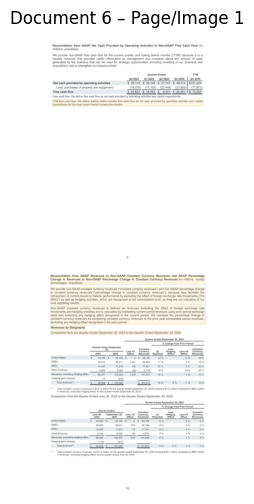


--- Processing Document 7 ---
  Page/Image 1


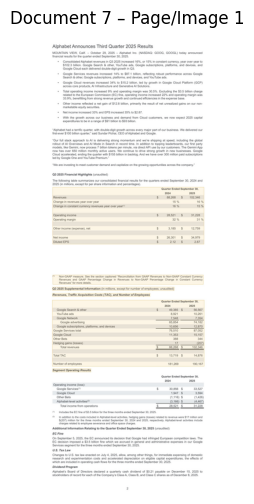


--- Processing Document 8 ---
  Page/Image 1


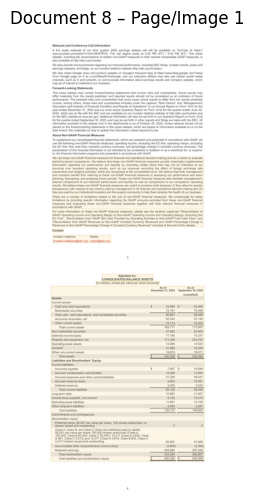


--- Processing Document 9 ---
  Page/Image 1


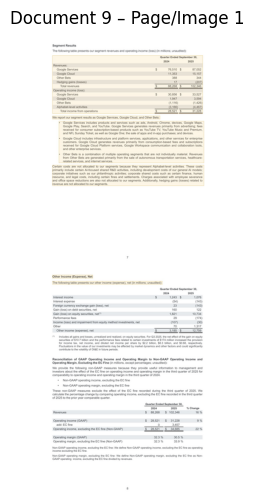


--- Processing Document 10 ---
  Page/Image 1


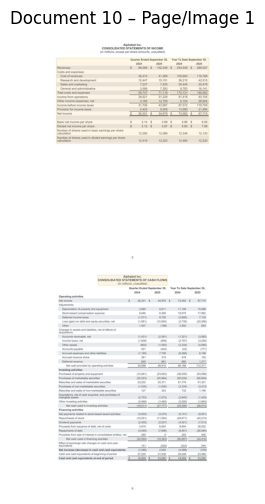


--- Processing Document 11 ---
  Page/Image 1


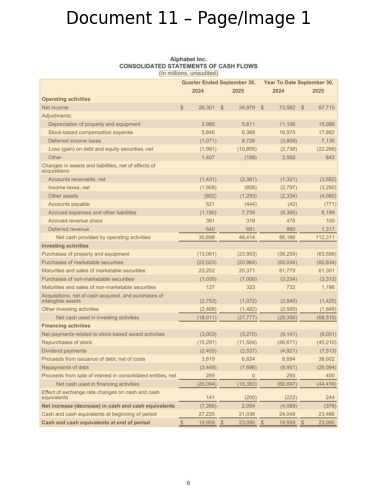


--- Processing Document 12 ---
  Page/Image 1


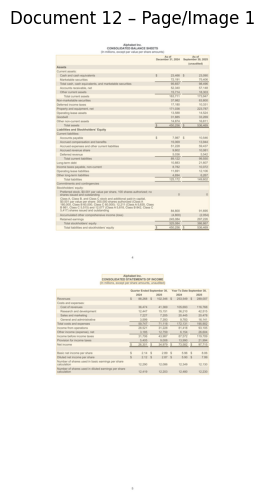


--- Processing Document 13 ---
  Page/Image 1


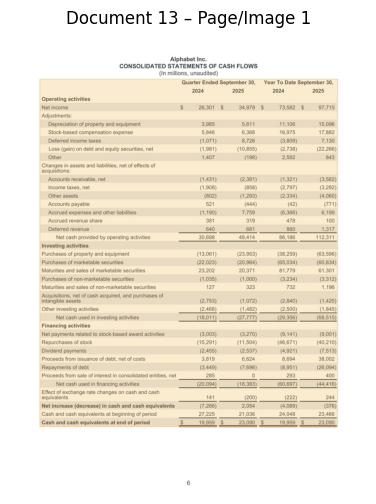


--- Processing Document 14 ---
  Page/Image 1


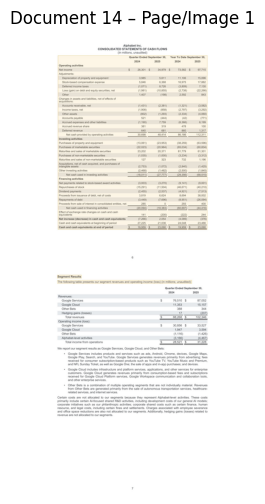


--- Processing Document 15 ---
  Page/Image 1


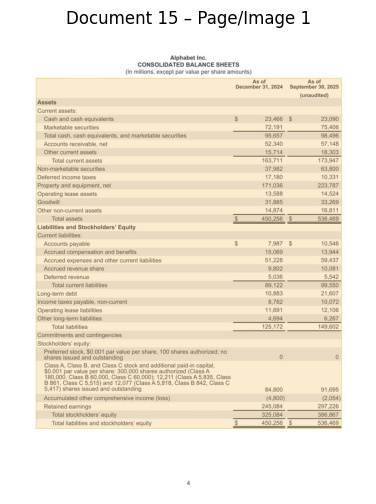


Total documents processed: 15


In [14]:
import base64
import io
from PIL import Image
import matplotlib.pyplot as plt

def display_base64_image(
    base64_string,
    title="Document",
    max_size=(800, 800)  # limits resolution
):
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize to keep notebook lightweight
    img.thumbnail(max_size, Image.Resampling.LANCZOS)

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(title)
    plt.show()

    return img


# Retrieve and display all referenced documents
for i, retrieval_content in enumerate(query_result.retrieval_contents):
    print(f"\n--- Processing Document {i+1} ---")

    ret_result = client.agents.query.retrieval_info(
        message_id=query_result.message_id,
        agent_id=agent_id,
        content_ids=[retrieval_content.content_id]
    )

    if not ret_result.content_metadatas:
        print("No metadata found")
        continue

    for j, meta in enumerate(ret_result.content_metadatas):
        print(f"  Page/Image {j+1}")

        # Try all known image fields safely
        base64_img = (
            meta.page_img
            or getattr(meta, "raw_img", None)
            or getattr(meta, "image", None)
        )

        if base64_img:
            display_base64_image(
                base64_img,
                title=f"Document {i+1} – Page/Image {j+1}"
            )
        else:
            print("  No image available")


print(f"\nTotal documents processed: {len(query_result.retrieval_contents)}")

# RAG Components Deep Dive
**Four key components of a production-grade RAG system:**

1. Document Parser
2. Instruction-Following Reranker
3. Grounded Language Model (GLM)
4. LMUnit: Natural Language Unit Testing

One key component is Datastore. We use ElasticSearch vector database in our production ready RAG system, and have only included the components built by Contextual AI above.

## 1. Document Parser

Parsing complex, unstructured documents is the critical foundation for agentic RAG systems. Failures in parsing cause these systems to miss critical context, degrading response accuracy.

The document parser used in our case combines the best of custom vision, OCR, and vision language models, along with specialized tools like table extractors—achieving superior accuracy and reliability by excelling in the following areas:

- **Document-level understanding vs. page-by-page parsing**: The parser understands the section hierarchies of long documents, equipping AI agents to understand relationships across hundreds of pages to generate contextually supported, accurate answers.
- **Minimized hallucinations**: The multi-stage pipeline minimizes severe hallucinations while providing accurate bounding boxes and confidence levels for table extraction to audit its output.
- **Superior handling of complex modalities**: The advanced system orchestrates the best models and specialized tools to handle the most challenging document elements, such as tables, charts, and figures.


### Document Hierarchy

Unlike traditional parsers, Contextual AI's solution understands how each page fits within the document's holistic structure and hierarchy, enabling AI agents to navigate long, complex documents with the same understanding a human would have. We automatically infer a document's hierarchy and structure, which enables developers to add metadata to each chunk that describes its position in the document. This improves retrieval and allows agents to understand how different sections relate to each other to provide answers that connect information across hundreds of pages.

For more information about Contextual AI's document parser, you can read this [blog](https://contextual.ai/blog/document-parser-for-rag/?utm_campaign=rag-techniques&utm_source=diamantai&utm_medium=github&utm_content=notebook).

Now, let's use ContextualAI's parser to parse the landmark "Attention is All You Need" paper to demonstrate the parser's capabilities.

In [15]:
# Download the Attention is All You Need paper from arXiv
url = "https://arxiv.org/pdf/1706.03762"
file_path = "data/attention-is-all-you-need.pdf"

with open(file_path, "wb") as f:
    f.write(requests.get(url).content)

print(f"Downloaded paper to {file_path}")

Downloaded paper to data/attention-is-all-you-need.pdf


We'll configure the parser with the following settings:
- **parse_mode**: "standard" for complex documents that require VLMs and OCR
- **figure_caption_mode**: "concise" for brief figure descriptions
- **enable_document_hierarchy**: True to capture document structure
- **page_range**: "0-5" to parse the first 6 pages

In [16]:
# Setup headers for direct API calls
base_url = "https://api.contextual.ai/v1"
headers = {
    "accept": "application/json",
    "authorization": f"Bearer {API_KEY}"
}

# Submit parse job
url = f"{base_url}/parse"

config = {
    "parse_mode": "standard",
    "figure_caption_mode": "concise",
    "enable_document_hierarchy": True,
    "page_range": "0-5",
}

with open(file_path, "rb") as fp:
    file = {"raw_file": fp}
    result = requests.post(url, headers=headers, data=config, files=file)
    response = json.loads(result.text)

job_id = response['job_id']
print(f"Parse job submitted with ID: {job_id}")

Parse job submitted with ID: 12b80519-5994-494e-be85-b98f6cd048a1



Now let's retrieve the parsed results. The parser provides multiple output types:
- **Markdown-document**: A single Markdown for the entire document
- **Markdown-per-page**: A list of Markdowns for each page of the document
- **Blocks-per-page**: Structured JSON representations of content blocks sorted by reading order

In [21]:
# Get the parse results
url = f"{base_url}/parse/jobs/{job_id}/results"

output_types = ["markdown-per-page"]

result = requests.get(
    url,
    headers=headers,
    params={"output_types": ",".join(output_types)},
)

result = json.loads(result.text)
print(f"Parse job is {result['status']}.")

Parse job is completed.


When the parse job is completed (e.g., the above status is "Parse job is completed. "), we can  examine the parsed content from the first page of the paper:

In [18]:
# Display the first page's parsed markdown
if 'pages' in result and len(result['pages']) > 0:
    display(Markdown(result['pages'][0]['markdown']))
else:
    print("No parsed content available. Please check if the job completed successfully.")

Provided proper attribution is provided, Google hereby grants permission to reproduce the tables and figures in this paper solely for use in journalistic or scholarly works.

# Attention Is All You Need

Noam Shazeer ∗ Google Brain noam@google.com

Ashish Vaswani ∗ Google Brain avaswani@google.com

Niki Parmar ∗ Google Research nikip@google.com

Jakob Uszkoreit ∗ Google Research usz@google.com

Aidan N. Gomez ∗† University of Toronto aidan@cs.toronto.edu

Llion Jones ∗ Google Research llion@google.com

Łukasz Kaiser ∗ Google Brain lukaszkaiser@google.com

Illia Polosukhin ∗‡ illia.polosukhin@gmail.com

## Abstract

The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring significantly less time to train. Our model achieves 28.4 BLEU on the WMT 2014 English- to-German translation task, improving over the existing best results, including ensembles, by over 2 BLEU. On the WMT 2014 English-to-French translation task, our model establishes a new single-model state-of-the-art BLEU score of 41.8 after training for 3.5 days on eight GPUs, a small fraction of the training costs of the best models from the literature. We show that the Transformer generalizes well to other tasks by applying it successfully to English constituency parsing both with large and limited training data.

∗ Equal contribution. Listing order is random. Jakob proposed replacing RNNs with self-attention and started the effort to evaluate this idea. Ashish, with Illia, designed and implemented the first Transformer models and has been crucially involved in every aspect of this work. Noam proposed scaled dot-product attention, multi-head attention and the parameter-free position representation and became the other person involved in nearly every detail. Niki designed, implemented, tuned and evaluated countless model variants in our original codebase and tensor2tensor. Llion also experimented with novel model variants, was responsible for our initial codebase, and efficient inference and visualizations. Lukasz and Aidan spent countless long days designing various parts of and implementing tensor2tensor, replacing our earlier codebase, greatly improving results and massively accelerating our research.

† Work performed while at Google Brain.

‡ Work performed while at Google Research.

To see job results in an interactive manner and submit new jobs, navigate to the UI using the following link by running the cell below. Note you'll need to change `"your-tenant-name"` to your tenant.

In [22]:
tenant = "samruddhi"
print(f"https://app.contextual.ai/{tenant}/components/parse?job={job_id}")

https://app.contextual.ai/samruddhi/components/parse?job=12b80519-5994-494e-be85-b98f6cd048a1


<div align="center">
<img src="https://raw.githubusercontent.com/ContextualAI/examples/6cb206bdaaf158fcdf2b01c102291c64381cba7a/03-standalone-api/04-parse/parse-ui.png" alt="Document Hierarchy" width="1000"/>
</div>



## 2. Instruction-Following Reranker

Enterprise RAG systems often deal with conflicting information in their knowledge bases. Marketing materials can conflict with product materials, documents in Google Drive could conflict with those in Microsoft Office, Q2 notes conflict with Q1 notes, and so on. You can tell our reranker how to resolve these conflicts with instructions like:

- "Prioritize internal sales documents over market analysis reports. More recent documents should be weighted higher. Enterprise portal content supersedes distributor communications."
- "Emphasize forecasts from top-tier investment banks. Recent analysis should take precedence. Disregard aggregator sites and favor detailed research notes over news summaries."

This enables an unprecedented level of control that improves RAG performance significantly.


### State-of-the-Art Performance

Contextual AI's SOTA reranker (v2) is the most accurate in the world with or without instructions - outperforming competitors by large margins on the industry-standard BEIR benchmark (V1), internal financial and field engineering datasets (V1), and novel instruction-following reranker evaluation datasets (V1).

In [23]:
# Define our query and instruction
query = "What is the current enterprise pricing for the RTX 5090 GPU for bulk orders?"

instruction = "Prioritize internal sales documents over market analysis reports. More recent documents should be weighted higher. Enterprise portal content supersedes distributor communications."

# Sample documents with conflicting information
documents = [
    "Following detailed cost analysis and market research, we have implemented the following changes: AI training clusters will see a 15% uplift in raw compute performance, enterprise support packages are being restructured, and bulk procurement programs (100+ units) for the RTX 5090 Enterprise series will operate on a $2,899 baseline.",
    "Enterprise pricing for the RTX 5090 GPU bulk orders (100+ units) is currently set at $3,100-$3,300 per unit. This pricing for RTX 5090 enterprise bulk orders has been confirmed across all major distribution channels.",
    "RTX 5090 Enterprise GPU requires 450W TDP and 20% cooling overhead."
]

# Metadata that helps distinguish document sources and dates
metadata = [
    "Date: January 15, 2025. Source: NVIDIA Enterprise Sales Portal. Classification: Internal Use Only",
    "TechAnalytics Research Group. 11/30/2023.",
    "January 25, 2025; NVIDIA Enterprise Sales Portal; Internal Use Only"
]

# Use the instruction-following reranker model
model = "ctxl-rerank-en-v1-instruct"

Now let's see how the reranker processes our query and instructions to properly rank the documents:

In [24]:
# Execute the reranking
rerank_response = client.rerank.create(
    query=query,
    instruction=instruction,
    documents=documents,
    metadata=metadata,
    model=model
)

print("Reranking Results:")
print("=" * 50)
print(rerank_response.to_dict())

Reranking Results:
{'results': [{'index': 0, 'relevance_score': 0.99995809}, {'index': 1, 'relevance_score': 0.99911428}, {'index': 2, 'relevance_score': 0.99082611}]}


Let's examine how the reranker prioritized the documents based on our instructions:

In [25]:
# Display ranked results in a more readable format
print("\nRanked Documents (by relevance score):")
print("=" * 60)

for i, result in enumerate(rerank_response.results):
    doc_index = result.index
    score = result.relevance_score

    print(f"\nRank {i+1}: Score {score:.4f}")
    print(f"Document {doc_index + 1}:")
    print(f"Content: {documents[doc_index][:100]}...")
    print(f"Metadata: {metadata[doc_index]}")
    print("-" * 40)


Ranked Documents (by relevance score):

Rank 1: Score 1.0000
Document 1:
Content: Following detailed cost analysis and market research, we have implemented the following changes: AI ...
Metadata: Date: January 15, 2025. Source: NVIDIA Enterprise Sales Portal. Classification: Internal Use Only
----------------------------------------

Rank 2: Score 0.9991
Document 2:
Content: Enterprise pricing for the RTX 5090 GPU bulk orders (100+ units) is currently set at $3,100-$3,300 p...
Metadata: TechAnalytics Research Group. 11/30/2023.
----------------------------------------

Rank 3: Score 0.9908
Document 3:
Content: RTX 5090 Enterprise GPU requires 450W TDP and 20% cooling overhead....
Metadata: January 25, 2025; NVIDIA Enterprise Sales Portal; Internal Use Only
----------------------------------------


Let's compare how the same documents are ranked without specific instructions to see the difference:

In [26]:
# Rerank without instructions for comparison
rerank_no_instruction = client.rerank.create(
    query=query,
    documents=documents,
    metadata=metadata,
    model=model
)

print("\nRanking WITHOUT Instructions:")
print("=" * 50)

for i, result in enumerate(rerank_no_instruction.results):
    doc_index = result.index
    score = result.relevance_score

    print(f"Rank {i+1}: Document {doc_index + 1}, Score: {score:.4f}")

print("\nRanking WITH Instructions:")
print("=" * 50)

for i, result in enumerate(rerank_response.results):
    doc_index = result.index
    score = result.relevance_score

    print(f"Rank {i+1}: Document {doc_index + 1}, Score: {score:.4f}")


Ranking WITHOUT Instructions:
Rank 1: Document 2, Score: 0.9998
Rank 2: Document 1, Score: 0.9989
Rank 3: Document 3, Score: 0.6656

Ranking WITH Instructions:
Rank 1: Document 1, Score: 1.0000
Rank 2: Document 2, Score: 0.9991
Rank 3: Document 3, Score: 0.9908


## 3. Grounded Language Model (GLM)

Contextual AI's Grounded Language Model (GLM) is the most grounded language model in the world, engineered specifically to minimize hallucinations for RAG and agentic use cases.

With state-of-the-art performance on [FACTS](https://www.kaggle.com/benchmarks/google/facts-grounding) (the leading groundedness benchmark) and our customer datasets, the GLM is the single best language model for RAG and agentic use cases for which minimizing hallucinations is critical. You can trust that the GLM will stick to the knowledge sources you give it.

In enterprise AI applications, **hallucinations** from the LLM pose a critical risk that can degrade customer experience, damage company reputation, and misguide business decisions. Yet the ability to hallucinate is seen as a useful feature in general-purpose foundation models, especially in serving consumer queries that require creative, novel responses. In contrast, the GLM is engineered specifically to minimize hallucinations for RAG and agentic use cases – delivering precise responses that are strongly grounded in and attributable to specific retrieved source data, not its parametric knowledge learned from training data.


### Groundedness Definition

**"Groundedness"** refers to the degree to which an LLM's generated output is supported by and accurately reflects the retrieved information provided to it. Given a query and a set of documents, a grounded model either responds only with relevant information from the documents or declines to answer if the documents are not relevant. In contrast, an ungrounded model may hallucinate based on patterns learned from its training data.


Let's demonstrate the GLM's ability to generate grounded responses using comprehensive knowledge sources about renewable energy in developing nations.

In [52]:
# Example conversation messages
messages = [
    {
        "role": "user",
        "content": "What are the most promising renewable energy technologies for addressing climate change in developing nations?"
    },
    {
        "role": "assistant",
        "content": "Based on current research, solar and wind power show significant potential for developing nations due to decreasing costs and scalability. Would you like to know more about specific implementation challenges and success stories?"
    },
    {
        "role": "user",
        "content": "Yes, please tell me about successful solar implementations in Africa and their economic impact, particularly focusing on rural electrification."
    }
]

# Detailed knowledge sources with varied information
knowledge = [
    """According to the International Renewable Energy Agency (IRENA) 2023 report:
    - Solar PV installations in Africa reached 10.4 GW in 2022
    - The cost of solar PV modules decreased by 80% between 2010 and 2022
    - Rural electrification projects have provided power to 17 million households""",

    """Case Study: Rural Electrification in Kenya (2020-2023)
    - 2.5 million households connected through mini-grid systems
    - Average household income increased by 35% after electrification
    - Local businesses reported 47% growth in revenue
    - Education outcomes improved with 3 additional study hours per day""",

    """Economic Analysis of Solar Projects in Sub-Saharan Africa:
    - Job creation: 25 jobs per MW of installed capacity
    - ROI average of 12-15% for mini-grid projects
    - Reduced energy costs by 60% compared to diesel generators
    - Carbon emissions reduction: 2.3 million tonnes CO2 equivalent""",

    """Technical Specifications and Best Practices:
    - Optimal solar panel efficiency in African climate conditions: 15-22%
    - Battery storage requirements: 4-8 kWh per household
    - Maintenance costs: $0.02-0.04 per kWh
    - Expected system lifetime: 20-25 years""",

    """Social Impact Assessment:
    - Women-led businesses increased by 45% in electrified areas
    - Healthcare facilities reported 72% improvement in service delivery
    - Mobile money usage increased by 60%
    - Agricultural productivity improved by 28% with electric irrigation"""
]


Now let's use the GLM to generate a grounded response based on the provided knowledge sources:

In [ ]:
# Setup for direct API call
base_url = "https://api.contextual.ai/v1"
generate_api_endpoint = f"{base_url}/generate"

headers = {
    "accept": "application/json",
    "content-type": "application/json",
    "authorization": f"Bearer {API_KEY}"
}

# Configure the GLM request
payload = {
    "model": "v1",
    "messages": messages,
    "knowledge": knowledge,
    "avoid_commentary": False,
    "max_new_tokens": 1024,
    "temperature": 0,
    "top_p": 0.9
}

# Generate the response
generate_response = requests.post(generate_api_endpoint, json=payload, headers=headers)

print("GLM Grounded Response:")
print("=" * 50)
print(generate_response.json()['response'])

GLM Grounded Response:
Let me share the current state of solar energy implementation in Africa, focusing on rural electrification and its economic impact:

Africa has seen significant solar PV adoption, with total installations reaching 10.4 GW by 2022, supported by an 80% decrease in solar PV module costs between 2010 and 2022.

The impact on rural electrification has been particularly noteworthy:

Key achievements include:
- 17 million households have gained access to electricity through rural electrification projects
- In Kenya specifically, 2.5 million households have been connected through mini-grid systems between 2020-2023

The economic benefits have been substantial:

Direct economic impacts include:
- Average household income increased by 35% after electrification
- Local businesses experienced 47% revenue growth
- Solar projects create approximately 25 jobs per MW of installed capacity
- Mini-grid projects typically achieve a 12-15% return on investment
- Energy costs have be

In [ ]:
# Generate response with avoid_commentary enabled
payload_no_commentary = payload.copy()
payload_no_commentary["avoid_commentary"] = True

generate_response_no_commentary = requests.post(generate_api_endpoint, json=payload_no_commentary, headers=headers)

print("GLM Response (with avoid_commentary=True):")
print("=" * 50)
print(generate_response_no_commentary.json()['response'])

GLM Response (with avoid_commentary=True):
Africa has seen significant solar energy adoption, with total solar PV installations reaching 10.4 GW by 2022, driven by an 80% decrease in solar module costs since 2010. These efforts have already provided electricity to 17 million households through rural electrification projects.



In Kenya, a notable case study from 2020-2023 demonstrated substantial economic benefits:
- 2.5 million households were connected through mini-grid systems
- Average household income increased by 35%
- Local businesses saw 47% revenue growth
- Students gained 3 additional study hours per day

The economic impact extends beyond individual households:
- Solar projects create 25 jobs per MW of installed capacity
- Mini-grid projects typically achieve 12-15% ROI
- Energy costs have been reduced by 60% compared to diesel generators
- These initiatives have resulted in 2.3 million tonnes CO2 equivalent in emissions reduction

The social impact has been particularly si

In [ ]:
print("COMPARISON:")
print("=" * 60)
print("\n1. Standard GLM Response (avoid_commentary=False):")
print("-" * 50)
print(generate_response.json()['response'])

print("\n\n2. Strict Grounding Mode (avoid_commentary=True):")
print("-" * 50)
print(generate_response_no_commentary.json()['response'])

print("\n\nKey Differences:")
print("- Standard mode may include helpful context and commentary")
print("- Strict mode focuses purely on information from knowledge sources")
print("- Both modes maintain strong grounding in provided sources")

COMPARISON:

1. Standard GLM Response (avoid_commentary=False):
--------------------------------------------------
Let me share the current state of solar energy implementation in Africa, focusing on rural electrification and its economic impact:

Africa has seen significant solar PV adoption, with total installations reaching 10.4 GW by 2022, supported by an 80% decrease in solar PV module costs between 2010 and 2022.

The impact on rural electrification has been particularly noteworthy:

Key achievements include:
- 17 million households have gained access to electricity through rural electrification projects
- In Kenya specifically, 2.5 million households have been connected through mini-grid systems between 2020-2023

The economic benefits have been substantial:

Direct economic impacts include:
- Average household income increased by 35% after electrification
- Local businesses experienced 47% revenue growth
- Solar projects create approximately 25 jobs per MW of installed capacity


Let's test how the GLM handles a query when provided with irrelevant knowledge sources:

In [ ]:
# Query about a completely different topic
different_query = [
    {
        "role": "user",
        "content": "What are the latest developments in quantum computing hardware?"
    }
]

# Same renewable energy knowledge (irrelevant to quantum computing)
irrelevant_payload = {
    "model": "v1",
    "messages": different_query,
    "knowledge": knowledge,  # Still about renewable energy
    "avoid_commentary": False,
    "max_new_tokens": 512,
    "temperature": 0,
    "top_p": 0.9
}

irrelevant_response = requests.post(generate_api_endpoint, json=irrelevant_payload, headers=headers)

print("GLM Response to Irrelevant Query:")
print("=" * 50)
print("Query: What are the latest developments in quantum computing hardware?")
print("Knowledge provided: Renewable energy information")
print("\nGLM Response:")
print(irrelevant_response.json()['response'])

GLM Response to Irrelevant Query:
Query: What are the latest developments in quantum computing hardware?
Knowledge provided: Renewable energy information

GLM Response:
I apologize, but I don't have any documentation about quantum computing hardware developments. The information I have access to is entirely focused on renewable energy and solar power implementations in Africa. If you'd like to know about solar energy developments or rural electrification projects, I'd be happy to help with that!


For more example code for Contextual AI's Grounded Language Model, see our [GLM examples notebook](https://github.com/ContextualAI/examples/tree/main/03-standalone-api/02-generate?utm_campaign=rag-techniques&utm_source=diamantai&utm_medium=github&utm_content=notebook)

## 4. LMUnit: Natural Language Unit Testing

 Evaluation, while not part of the core RAG pipeline, is a critical component to validating a RAG system before deploying to production. LMUnit is a language model optimized for evaluating natural language unit tests. LMUnit brings the rigor, familiarity, and accessibility of traditional software engineering unit testing to Large Language Model (LLM) evaluation.

LMUnit sets the state of the art for fine-grained evaluation, as measured by FLASK and BiGGen Bench, and performs on par with frontier models for coarse evaluation of long-form responses (per LFQA). The model also demonstrates exceptional alignment with human preferences, ranking in the top 5 of the RewardBench benchmark with 93.5% accuracy.

### Natural Language Unit Tests

A unit test is a specific, clear, testable statement or question in natural language about a desirable quality of an LLM's response. Just as traditional unit tests check individual functions in software, unit tests in this paradigm evaluate discrete qualities of individual model outputs – from basic accuracy and formatting to complex reasoning and domain-specific requirements.

### Types of Unit Tests

- **Global unit tests**: Applied to all queries in an evaluation set (e.g., "Does the response maintain a formal style?")
- **Targeted unit tests**: Focused assessment of query-level details (e.g., for "Describe Stephen Curry's legacy" → "Does the response mention that Stephen Curry is the greatest shooter in NBA history?")


Let's start with a basic example to understand how LMUnit works. LMUnit takes three inputs: a query, a response, and a unit test, then produces a continuous score between 1 and 5.

In [40]:
# Simple example
query = "What was NVIDIA's Data Center revenue in Q4 FY25?"

response = """NVIDIA's Data Center revenue for Q4 FY25 was $35,580 million.

This represents a significant increase from the previous quarter (Q3 FY25) when Data Center revenue was $30,771 million.

The full quarterly trend for Data Center revenue in FY25 was:
- Q4 FY25: $35,580 million
- Q3 FY25: $30,771 million
- Q2 FY25: $26,272 million
- Q1 FY25: $22,563 million"""

unit_test = "Does the response avoid unnecessary information?"

# Evaluate with LMUnit
result = client.lmunit.create(
    query=query,
    response=response,
    unit_test=unit_test
)

print(f"Unit Test: {unit_test}")
print(f"Score: {result.score}/5")
print(f"\nAnalysis: The response includes additional quarterly trends beyond the specific Q4 request,")
print(f"which explains the lower score for avoiding unnecessary information.")

Unit Test: Does the response avoid unnecessary information?
Score: 1.96/5

Analysis: The response includes additional quarterly trends beyond the specific Q4 request,
which explains the lower score for avoiding unnecessary information.


Based on this score, you could adjust your system prompt to specifically exclude any information besides the exact response needed to address the query.

Let's define a comprehensive set of unit tests for evaluating quantitative reasoning responses:

In [41]:
# Define comprehensive unit tests for quantitative reasoning
unit_tests = [
    "Does the response accurately extract specific numerical data from the documents?",
    "Does the agent properly distinguish between correlation and causation?",
    "Are multi-document comparisons performed correctly with accurate calculations?",
    "Are potential limitations or uncertainties in the data clearly acknowledged?",
    "Are quantitative claims properly supported with specific evidence from the source documents?",
    "Does the response avoid unnecessary information?"
]

# Create category mapping for visualization
test_categories = {
    'Does the response accurately extract specific numerical data': 'ACCURACY',
    'Does the agent properly distinguish between correlation and causation': 'CAUSATION',
    'Are multi-document comparisons performed correctly': 'SYNTHESIS',
    'Are potential limitations or uncertainties in the data': 'LIMITATIONS',
    'Are quantitative claims properly supported with specific evidence': 'EVIDENCE',
    'Does the response avoid unnecessary information': 'RELEVANCE'
}

print("Unit Test Framework:")
print("=" * 50)
for i, test in enumerate(unit_tests, 1):
    category = next((v for k, v in test_categories.items() if k.lower() in test.lower()), 'OTHER')
    print(f"{i}. {category}: {test}")

Unit Test Framework:
1. ACCURACY: Does the response accurately extract specific numerical data from the documents?
2. CAUSATION: Does the agent properly distinguish between correlation and causation?
3. SYNTHESIS: Are multi-document comparisons performed correctly with accurate calculations?
4. LIMITATIONS: Are potential limitations or uncertainties in the data clearly acknowledged?
5. EVIDENCE: Are quantitative claims properly supported with specific evidence from the source documents?
6. RELEVANCE: Does the response avoid unnecessary information?


We can also create sample prompt-response pairs for evaluation:

In [42]:
# Sample evaluation dataset
evaluation_data = [
    {
        "prompt": "What was NVIDIA's Data Center revenue in Q4 FY25?",
        "response": "NVIDIA's Data Center revenue for Q4 FY25 was $35,580 million. This represents a significant increase from the previous quarter."
    },
    {
        "prompt": "What is the correlation coefficient between Neptune's distance from the Sun and US burglary rates?",
        "response": "According to the Tyler Vigen spurious correlations dataset, there is a correlation coefficient of 0.87 between Neptune's distance from the Sun and US burglary rates. However, this is clearly a spurious correlation with no causal relationship."
    },
    {
        "prompt": "How did NVIDIA's total revenue change from Q1 FY22 to Q4 FY25?",
        "response": "NVIDIA's total revenue grew from $5.66 billion in Q1 FY22 to $60.9 billion in Q4 FY25, representing a massive increase driven primarily by AI and data center demand."
    }
]

eval_df = pd.DataFrame(evaluation_data)
print("Sample Evaluation Dataset:")
print(eval_df.to_string(index=False))

Sample Evaluation Dataset:
                                                                                            prompt                                                                                                                                                                                                                                           response
                                                 What was NVIDIA's Data Center revenue in Q4 FY25?                                                                                                                    NVIDIA's Data Center revenue for Q4 FY25 was $35,580 million. This represents a significant increase from the previous quarter.
What is the correlation coefficient between Neptune's distance from the Sun and US burglary rates? According to the Tyler Vigen spurious correlations dataset, there is a correlation coefficient of 0.87 between Neptune's distance from the Sun and US burglary rates. However, this is clearly


Now let's run our unit tests across all evaluation examples:

In [43]:
def run_unit_tests_with_progress(
    df: pd.DataFrame,
    unit_tests: List[str]
) -> List[Dict]:
    """
    Run unit tests with progress tracking and error handling.
    """
    results = []

    for idx in tqdm(range(len(df)), desc="Processing responses"):
        row = df.iloc[idx]
        row_results = []

        for test in unit_tests:
            try:
                result = client.lmunit.create(
                    query=row['prompt'],
                    response=row['response'],
                    unit_test=test
                )

                row_results.append({
                    'test': test,
                    'score': result.score,
                    'metadata': result.metadata if hasattr(result, 'metadata') else None
                })

            except Exception as e:
                print(f"Error with prompt {idx}, test '{test}': {e}")
                row_results.append({
                    'test': test,
                    'score': None,
                    'error': str(e)
                })

        results.append({
            'prompt': row['prompt'],
            'response': row['response'],
            'test_results': row_results
        })

    return results

# Run the evaluation
print("Running comprehensive unit test evaluation...")
results = run_unit_tests_with_progress(eval_df, unit_tests)

# Display detailed results
for i, result in enumerate(results):
    print(f"\n{'='*60}")
    print(f"EVALUATION {i+1}")
    print(f"{'='*60}")
    print(f"Prompt: {result['prompt']}")
    print(f"Response: {result['response'][:100]}...")
    print("\nUnit Test Scores:")

    for test_result in result['test_results']:
        if 'score' in test_result and test_result['score'] is not None:
            category = next((v for k, v in test_categories.items() if k.lower() in test_result['test'].lower()), 'OTHER')
            print(f"  {category}: {test_result['score']:.2f}/5")
        else:
            print(f"  Error: {test_result.get('error', 'Unknown error')}")

Running comprehensive unit test evaluation...


Processing responses: 100%|██████████| 3/3 [00:49<00:00, 16.38s/it]


EVALUATION 1
Prompt: What was NVIDIA's Data Center revenue in Q4 FY25?
Response: NVIDIA's Data Center revenue for Q4 FY25 was $35,580 million. This represents a significant increase...

Unit Test Scores:
  ACCURACY: 1.86/5
  CAUSATION: 1.43/5
  SYNTHESIS: 1.79/5
  LIMITATIONS: 1.16/5
  EVIDENCE: 1.41/5
  RELEVANCE: 3.75/5

EVALUATION 2
Prompt: What is the correlation coefficient between Neptune's distance from the Sun and US burglary rates?
Response: According to the Tyler Vigen spurious correlations dataset, there is a correlation coefficient of 0....

Unit Test Scores:
  ACCURACY: 4.20/5
  CAUSATION: 4.90/5
  SYNTHESIS: 2.75/5
  LIMITATIONS: 4.66/5
  EVIDENCE: 3.99/5
  RELEVANCE: 3.75/5

EVALUATION 3
Prompt: How did NVIDIA's total revenue change from Q1 FY22 to Q4 FY25?
Response: NVIDIA's total revenue grew from $5.66 billion in Q1 FY22 to $60.9 billion in Q4 FY25, representing ...

Unit Test Scores:
  ACCURACY: 3.24/5
  CAUSATION: 2.76/5
  SYNTHESIS: 3.18/5
  LIMITATIONS: 1.15/5
  


Let's create polar plots to visualize the unit test results:

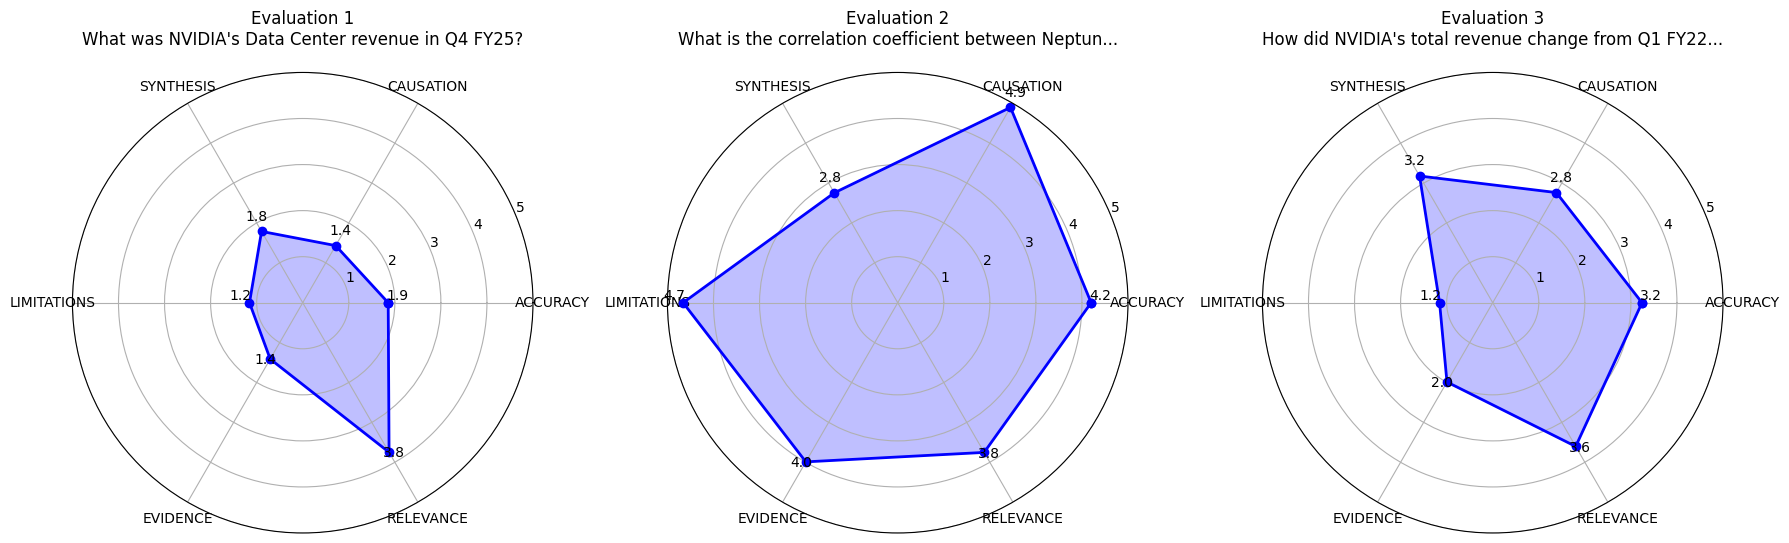

In [44]:
def map_test_to_category(test_question: str) -> str:
    """Map the full test question to its category."""
    for key, value in test_categories.items():
        if key.lower() in test_question.lower():
            return value
    return None

def create_unit_test_plots(results: List[Dict], test_indices: Optional[List[int]] = None):
    """
    Create polar plot(s) for unit test results.
    """
    if test_indices is None:
        test_indices = list(range(len(results)))
    elif isinstance(test_indices, int):
        test_indices = [test_indices]

    categories = ['ACCURACY', 'CAUSATION', 'SYNTHESIS', 'LIMITATIONS', 'EVIDENCE', 'RELEVANCE']
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))

    num_plots = len(test_indices)
    fig = plt.figure(figsize=(6 * num_plots, 6))

    for plot_idx, result_idx in enumerate(test_indices):
        result = results[result_idx]
        ax = plt.subplot(1, num_plots, plot_idx + 1, projection='polar')

        scores = []
        for category in categories:
            score = None
            for test_result in result['test_results']:
                mapped_category = map_test_to_category(test_result['test'])
                if mapped_category == category:
                    score = test_result['score']
                    break
            scores.append(score if score is not None else 0)

        scores = np.concatenate((scores, [scores[0]]))

        ax.plot(angles, scores, 'o-', linewidth=2, color='blue')
        ax.fill(angles, scores, alpha=0.25, color='blue')
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories)
        ax.set_ylim(0, 5)
        ax.grid(True)

        for angle, score, category in zip(angles[:-1], scores[:-1], categories):
            ax.text(angle, score + 0.2, f'{score:.1f}', ha='center', va='bottom')

        prompt = result['prompt'][:50] + "..." if len(result['prompt']) > 50 else result['prompt']
        ax.set_title(f"Evaluation {result_idx + 1}\n{prompt}", pad=20)

    plt.tight_layout()
    return fig

# Create visualizations
if len(results) > 0:
    fig = create_unit_test_plots(results)
    plt.show()
else:
    print("No results to visualize")


Let's analyze the overall performance across all categories:

In [45]:
# Create aggregate analysis
all_scores = []
for result in results:
    for test_result in result['test_results']:
        if 'score' in test_result and test_result['score'] is not None:
            category = map_test_to_category(test_result['test'])
            all_scores.append({
                'category': category,
                'score': test_result['score'],
                'test': test_result['test']
            })

scores_df = pd.DataFrame(all_scores)

if not scores_df.empty:
    # Calculate average scores by category
    avg_scores = scores_df.groupby('category')['score'].agg(['mean', 'std', 'count']).round(2)

    print("\nAggregate Performance by Category:")
    print("=" * 50)
    print(avg_scores)

    # Overall statistics
    print(f"\nOverall Statistics:")
    print(f"Mean Score: {scores_df['score'].mean():.2f}/5")
    print(f"Standard Deviation: {scores_df['score'].std():.2f}")
    print(f"Total Evaluations: {len(scores_df)}")
else:
    print("No valid scores to analyze")


Aggregate Performance by Category:
             mean   std  count
category                      
ACCURACY     3.10  1.18      3
CAUSATION    3.03  1.75      3
EVIDENCE     2.46  1.35      3
LIMITATIONS  2.32  2.02      3
RELEVANCE    3.70  0.09      3
SYNTHESIS    2.57  0.71      3

Overall Statistics:
Mean Score: 2.87/5
Standard Deviation: 1.23
Total Evaluations: 18
